# NSQIP Model 2

This notebook shows how we trained Model 2 for the paper: "*Deep Learning in Surgery - Assessing The Utility of Deep Neural Networks in Predicting Postoperative Surgical Complications: A Retrospective Study*"<br><br>
For privacy- and security reasons, we have chosen not to publish the identification numbers of the cases in our test set. Performance metrics will therefore vary slightly from the originally published results <br><br>
The NSQIP database can be requested through the American College of Surgeons website at<br>
https://facs.org <br><br>
Before running this notebook, the NSQIP data should be cleaned. An example notebook can be found at
https://github.com/alexbonde/NSQIP/blob/main/NSQIP_data_cleaning.ipynb

### Notebook setup

Import pre-installed packages 

In [1]:
import pandas as pd
from pathlib import Path
from fastai.tabular.all import *

Package versions: 
* *Python v. 3.7.7*<br>
* *Pandas v. 1.1.4*<br>
* *PyTorch v. 1.6.0*<br>
* *Fastai v. 2.0.11*

Set seed for reproducable results

In [2]:
seed = 42

# python RNG
import random
random.seed(seed)

# pytorch RNGs
import torch
torch.manual_seed(seed)
torch.backends.cudnn.deterministic = True
if torch.cuda.is_available(): torch.cuda.manual_seed_all(seed)

# numpy RNG
import numpy as np
np.random.seed(seed)

Create paths to NSQIP data folder

In [3]:
data_folder = Path(r'E:\Data\NSQIP')

Create subpaths to the folders: datasets and pickles

### Load and preprocess data

In [4]:
nsqip = pd.read_feather(data_folder/'nsqip')

Define categorical input variables

In [5]:
cat_names = ['CPT', 'SEX', 'FNSTATUS2', 'EMERGNCY', 'ASACLAS', 'STEROID', 'ASCITES', 'PRSEPIS', 
             'VENTILAT', 'DISCANCR', 'DIABETES', 'HYPERMED', 'HXCHF', 'DYSPNEA', 'SMOKE', 'HXCOPD', 
             'DIALYSIS', 'RENAFAIL', 'OperYR']

Define continuous input variables

In [6]:
cont_names = ['HEIGHT', 'WEIGHT', 'Age_cont', 'PRSODM', 'PRBUN', 'PRCREAT', 
             'PRALBUM', 'PRBILI', 'PRSGOT', 'PRALKPH', 'PRWBC', 'PRHCT', 
             'PRPLATE', 'PRPTT', 'PRINR', 'PRPT']

Define output variables

In [7]:
y_names=['SSSI', 'DSSI', 'OSSI', 'WOUND', 'PNEUMONIA', 'UNPINT', 'PE', 'VENT48', 'PRI', 'ARF', 'UTI', 'STROKE', 'CAR', 'MI', 'DVT', 'SEPSIS', 'SEPSHOCK', 'BLEED', 'DECEASED']

Split data randomly into a training dataset (80%) and a validation dataset (20%)

In [8]:
splits = RandomSplitter(seed=seed)(range_of(nsqip))

Define preprocessing steps:
* *FillMissing = Replace missing values with the median of the group while simultaneously creating a new binary column indicating whether a variable was missing or not*<br>
* *Categorify = Turn categorical variables into categories*<br
* *Normalize = Normalize continous data by subtraction of the mean and division by the standard deviation*

In [9]:
procs = [FillMissing, Categorify, Normalize]

### Create dataloaders

In [10]:
pd.options.mode.chained_assignment=None

In [11]:
%time to = TabularPandas(nsqip, procs, cat_names, cont_names, y_names=y_names, y_block=MultiCategoryBlock(encoded=True, vocab=y_names), splits=splits, inplace=True, reduce_memory=True)

Wall time: 2min 35s


In [12]:
dls = to.dataloaders(1024, num_workers=0)

### Create a Neural Network

We chose the following hyperparameters: 
* *Two hidden layers with 1000 and 500 nodes respectively (layers=[1000,500])*<br>
* *A dropout on the first hidden layer of 0.1% and a dropout on the second layer of 1% (ps=[0.001,0.01])*<br>
* *A dropout on the embedding layers of 4% (embed_p=0.04)*<br>

The number of outpus are 19 (one for each of the dependent variables, n_out = 19)<br>
For performance metrics, we were interested in the average ROC AUC (RocAucMulti()), as well as the ROC AUC for each of the dependent variables (RocAucMulti(average=None))


In [13]:
learn = tabular_learner(dls, layers=[1000,500], 
                        config=tabular_config(ps=[0.001,0.01], embed_p=0.04), 
                        n_out=19,
                        metrics=[RocAucMulti(),RocAucMulti(average=None)])

Print a summary of the network

In [14]:
learn.summary()

TabularModel (Input shape: ['1024 x 35', '1024 x 16'])
Layer (type)         Output Shape         Param #    Trainable 
Embedding            1024 x 140           411,880    True      
________________________________________________________________
Embedding            1024 x 3             9          True      
________________________________________________________________
Embedding            1024 x 3             12         True      
________________________________________________________________
Embedding            1024 x 3             9          True      
________________________________________________________________
Embedding            1024 x 4             24         True      
________________________________________________________________
Embedding            1024 x 3             9          True      
________________________________________________________________
Embedding            1024 x 3             9          True      
___________________________________________

### Train- and save the model

We chose to train each model for 5 epochs, with a learning rate of 3e-3 and a weight decay (wd) of 0.2

In [15]:
learn.fit_one_cycle(5, 3e-3, wd=0.2)

epoch,train_loss,valid_loss,roc_auc_score,roc_auc_score,time
0,0.034967,0.035723,0.851938,[0.7692 0.78841063 0.82693414 0.81570868 0.8613075 0.89106675 0.74384057 0.93492495 0.86087791 0.93172278 0.75275597 0.86676118 0.90029603 0.87012025 0.7883094 0.8163199 0.90204356 0.91931715 0.94689809],05:26
1,0.035212,0.034957,0.858708,[0.77477067 0.79847972 0.83814172 0.82165779 0.86615707 0.89603751 0.76653829 0.93596803 0.86986008 0.93383287 0.76568249 0.87014978 0.90420405 0.87439568 0.79775895 0.82346175 0.90681798 0.92267831 0.94885583],06:44
2,0.034920,0.034697,0.863151,[0.77804729 0.80695709 0.84298422 0.82781543 0.86907626 0.89797771 0.7747753 0.93850551 0.87479574 0.93570776 0.77045448 0.87560591 0.90572294 0.88127596 0.80624883 0.8286702 0.91062722 0.92401064 0.9506048 ],06:19
3,0.034097,0.034323,0.868530,[0.78691417 0.81567408 0.85001698 0.8372803 0.87279891 0.9009907 0.78368048 0.94101135 0.88215213 0.94078951 0.77457099 0.88194472 0.90862148 0.88723602 0.81230732 0.83356884 0.91447752 0.92592359 0.9521146 ],05:56
4,0.034083,0.034107,0.871021,[0.78984397 0.81912724 0.85330843 0.84030584 0.87483253 0.90276402 0.78955926 0.94233912 0.88519084 0.94217913 0.77937122 0.88409883 0.91032287 0.88814566 0.81548878 0.83645817 0.91584269 0.92728217 0.9529446 ],06:01


Save and export the model

In [16]:
learn.save('NSQIP_model_2')

Path('models/NSQIP_model_2.pth')

In [17]:
learn.export('NSQIP_model_2')

### Test the model on the validation dataset

We use the scitkit-learn package to calculate performance metrics 
* *Sklearn v. 0.23.1*

In [18]:
from sklearn.metrics import brier_score_loss, auc, roc_curve, roc_auc_score

Load the model

In [19]:
learn.load('NSQIP_model_2')

Get predictions for both the training and the validation datasets: 

In [20]:
preds_tens, ys = learn.get_preds(n_workers=0)

Create a seperate dataframe with only the validation data

In [21]:
trn, vld = RandomSplitter(seed=seed)(range_of(nsqip))

In [22]:
valid = nsqip.iloc[vld, :]

Add the prediction for each of the outputs to the validation dataframe

In [23]:
y_names=learn.dls.y_names
n_classes=len(y_names)

In [24]:
for x in range(n_classes):
    valid['y_score_'+(y_names[x])] = [i[x] for i in preds_tens.tolist()] 

The following code allows us to calculate 95% confidence intervals for the ROC AUC<br>
* *Published by Shuntaro Ohno (https://github.com/doraneko94)*

In [25]:
from math import sqrt

def roc_auc_ci(y_true, y_score, positive=1):
    AUC = roc_auc_score(y_true, y_score)
    N1 = sum(y_true == positive)
    N2 = sum(y_true != positive)
    Q1 = AUC / (2 - AUC)
    Q2 = 2*AUC**2 / (1 + AUC)
    SE_AUC = sqrt((AUC*(1 - AUC) + (N1 - 1)*(Q1 - AUC**2) + (N2 - 1)*(Q2 - AUC**2)) / (N1*N2))
    lower = AUC - 1.96*SE_AUC
    upper = AUC + 1.96*SE_AUC
    if lower < 0:
        lower = 0
    if upper > 1:
        upper = 1
    return (lower, AUC, upper)

Calculate ROC AUC's with 95% confidence intervals-, along with the Brier score, for each of the output variables

In [26]:
from sklearn.metrics import brier_score_loss

In [27]:
roc_values=[]
for i in range(n_classes):
    l,AUC,h = roc_auc_ci((valid[(y_names[i])]), preds_tens[:, i], positive=1)
    roc_values.append(AUC)
    b = brier_score_loss((valid[(y_names[i])]), preds_tens[:, i])
    print ((y_names[i]), 'roc_auc =', "%.3f" % AUC, '[',"%.3f" % l, ',', "%.3f" % h, '] Brier score =', 
          "%.5f" % b)

SSSI roc_auc = 0.790 [ 0.786 , 0.794 ] Brier score = 0.01345
DSSI roc_auc = 0.819 [ 0.812 , 0.827 ] Brier score = 0.00371
OSSI roc_auc = 0.853 [ 0.849 , 0.858 ] Brier score = 0.00853
WOUND roc_auc = 0.840 [ 0.833 , 0.848 ] Brier score = 0.00372
PNEUMONIA roc_auc = 0.875 [ 0.871 , 0.879 ] Brier score = 0.00899
UNPINT roc_auc = 0.903 [ 0.899 , 0.907 ] Brier score = 0.00709
PE roc_auc = 0.790 [ 0.781 , 0.798 ] Brier score = 0.00326
VENT48 roc_auc = 0.942 [ 0.939 , 0.946 ] Brier score = 0.00645
PRI roc_auc = 0.885 [ 0.877 , 0.893 ] Brier score = 0.00241
ARF roc_auc = 0.942 [ 0.937 , 0.948 ] Brier score = 0.00252
UTI roc_auc = 0.779 [ 0.775 , 0.784 ] Brier score = 0.01048
STROKE roc_auc = 0.884 [ 0.875 , 0.893 ] Brier score = 0.00187
CAR roc_auc = 0.910 [ 0.904 , 0.917 ] Brier score = 0.00295
MI roc_auc = 0.888 [ 0.882 , 0.895 ] Brier score = 0.00360
DVT roc_auc = 0.815 [ 0.809 , 0.822 ] Brier score = 0.00551
SEPSIS roc_auc = 0.836 [ 0.831 , 0.842 ] Brier score = 0.00745
SEPSHOCK roc_auc = 

Plot the ROC curves with the AUC

In [28]:
y_names_long=['Superficial SSI','Deep SSI','Organ space SSI','Wound disruption','Pneumonia',
              'Unplanned intubation','Pulmonary embolism','On ventilator >48 h',
              'Progressive renal insufficiency','Acute renal failure','Urinary tract infection',
              'Stroke/CVA','Cardiac arrest requiring CPR','Myocardial infarction ','DVT/thrombophlebitis',
              'Sepsis','Septic shock','Bleeding requiring transfusions','Mortality']

In [29]:
from collections import OrderedDict
d=dict(list(enumerate(roc_values)))
dd = OrderedDict(sorted(d.items(), key=lambda x: x[1], reverse=True))
roc_ordered=dd.keys()

In [30]:
colors = ['gold', 'orange', 'darkorange', 'saddlebrown', 'olive', 'lightskyblue', 'mediumblue',
         'darkolivegreen', 'peru', 'coral', 'wheat', 'darkcyan', 'orangered', 'lightseagreen', 'tomato', 
         'darkviolet', 'indigo', 'red', 'grey']

In [31]:
fpr = dict()
tpr = dict()
roc_auc = dict()
y_names=learn.dls.y_names
n_classes=len(y_names)
roc_values=[]

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(valid[(y_names[i])], preds_tens[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    roc_values.append(roc_auc[i])

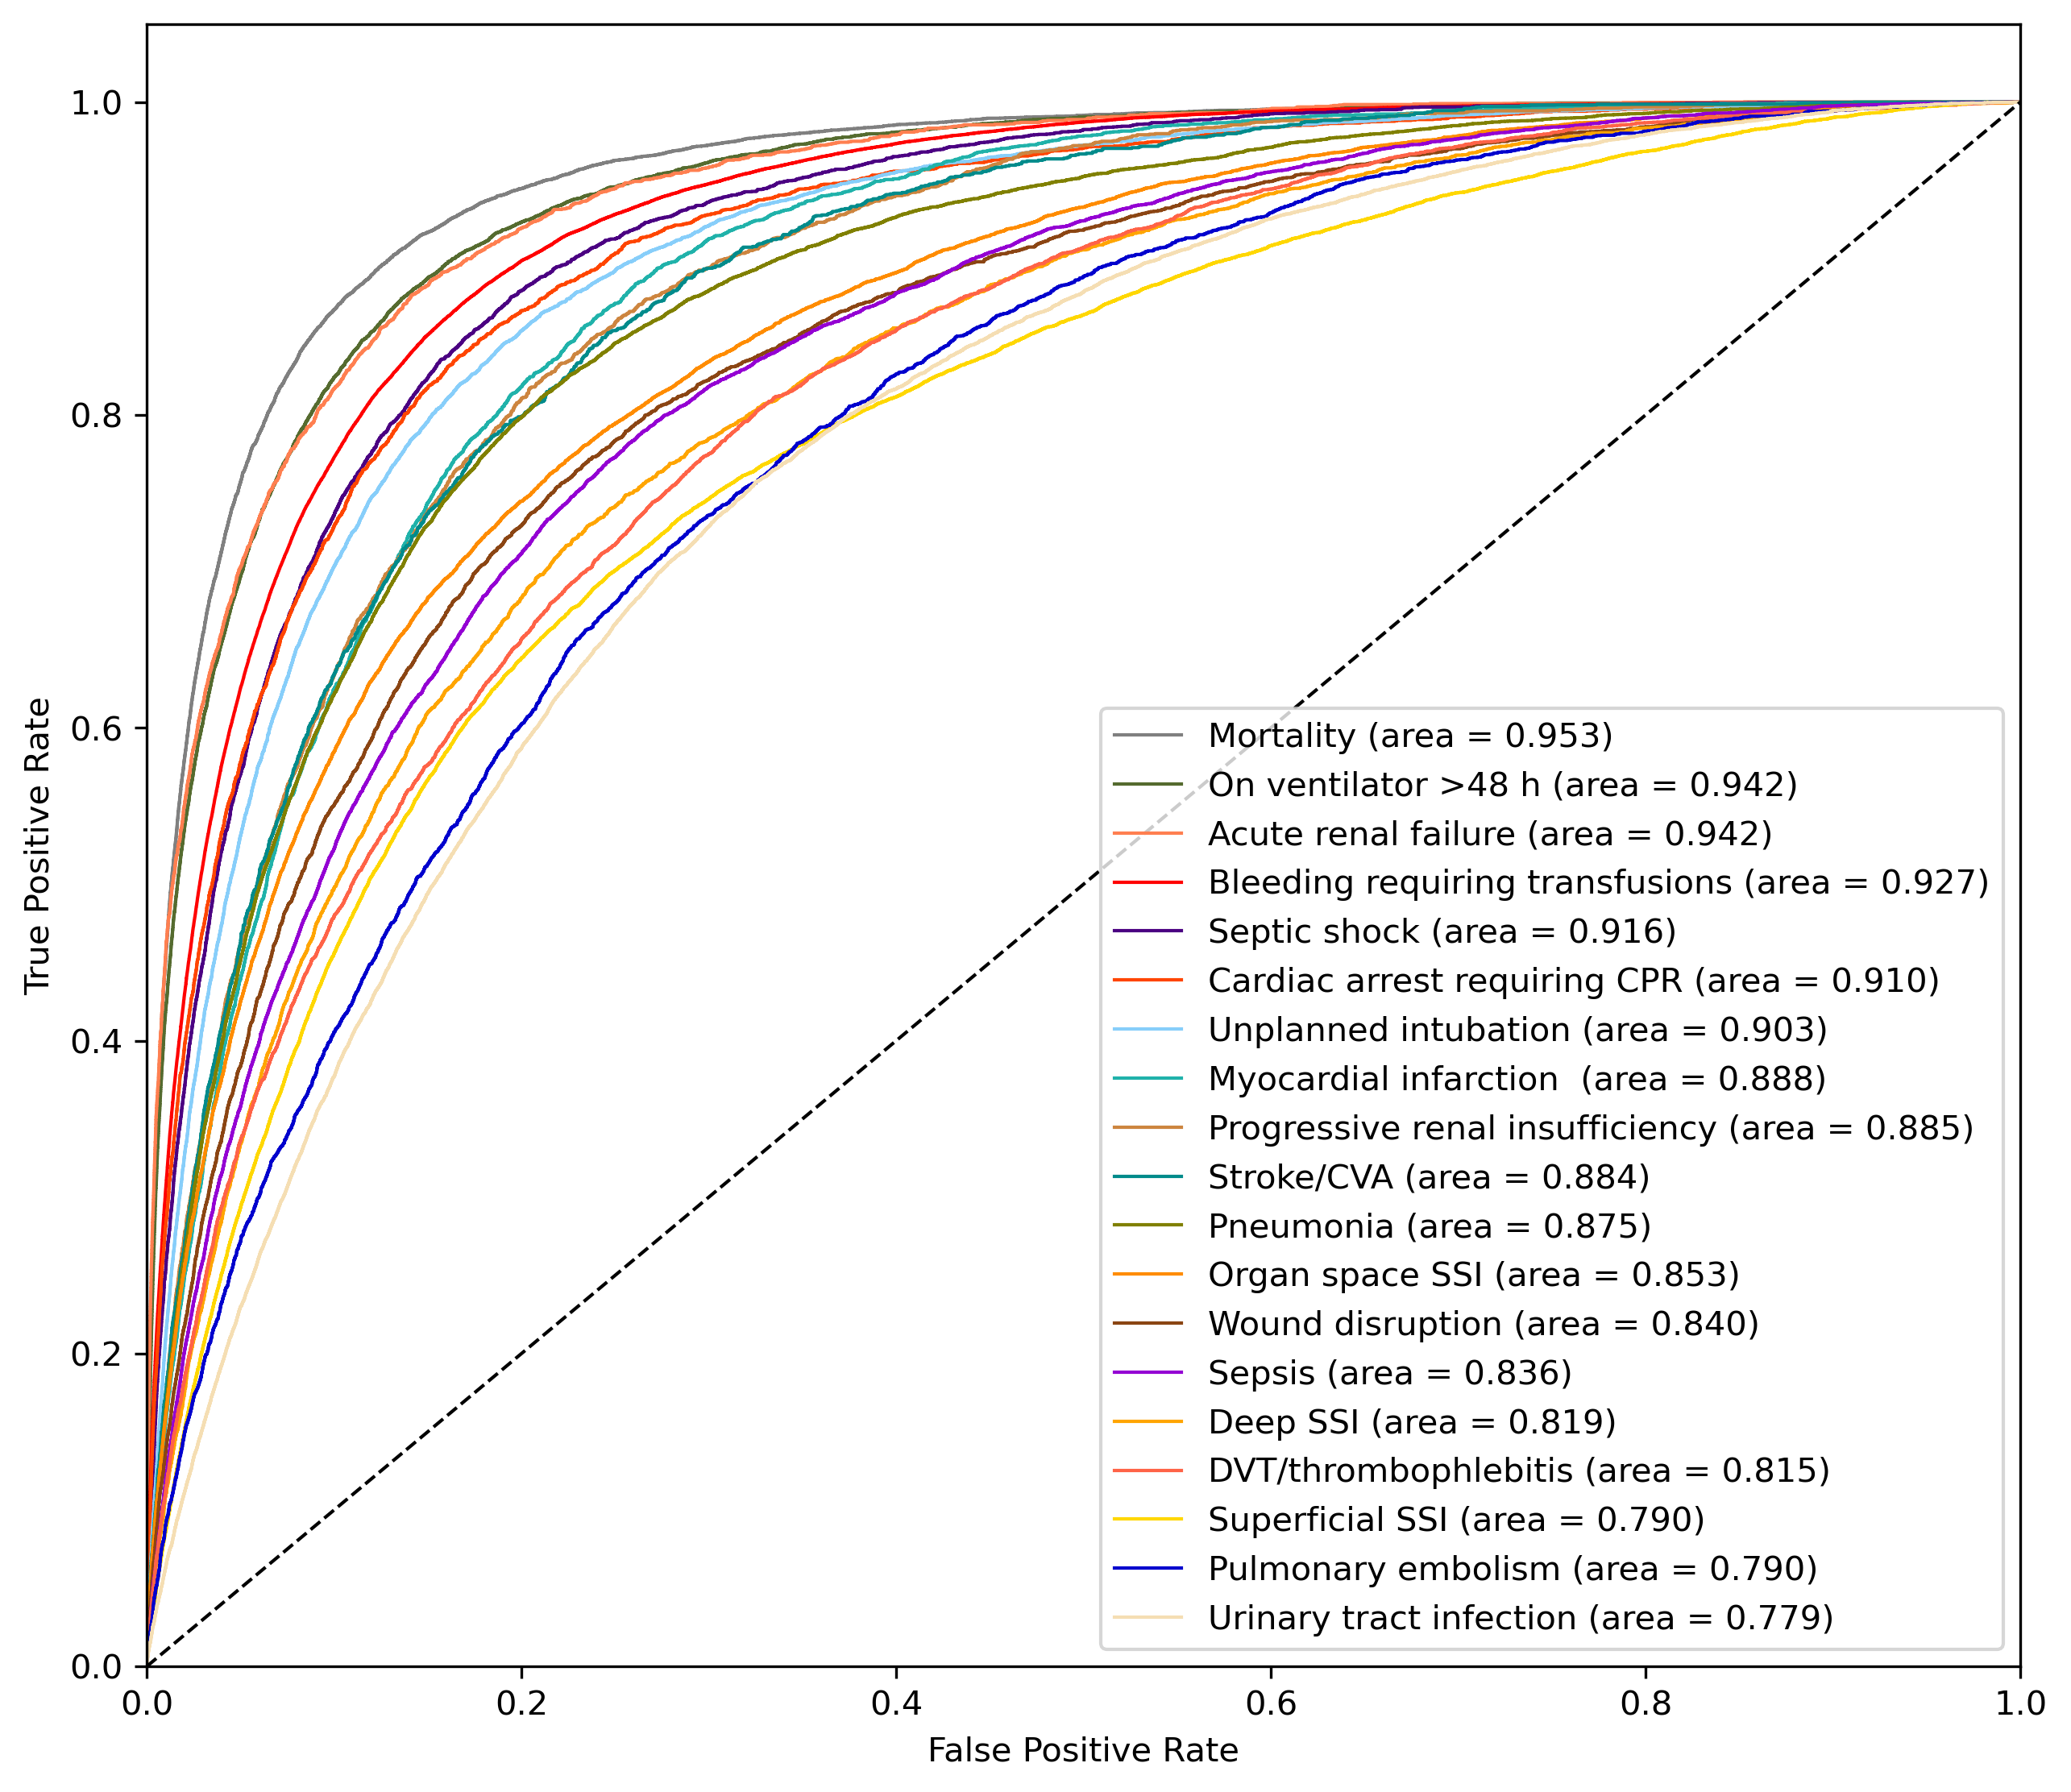

In [32]:
plt.figure(num=None, figsize=(10, 9), dpi=300, facecolor='w', edgecolor='k')

for i in(roc_ordered):
    plt.plot(fpr[i], tpr[i], color=colors[i], lw=1,
    label=y_names_long[i]+' (area = {1:0.3f})'''.format(i, roc_auc[i]))
plt.legend(loc="lower right")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.plot([0, 1], [0, 1], 'k--', lw=1)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.savefig('ROC_model_1.pdf', bbox_inches='tight')

Calculate performance metrics for composite outcomes

In [33]:
avROC={}
avROC['MORBIDITY'] = ['SSSI', 'DSSI', 'OSSI', 'WOUND', 'PNEUMONIA', 'UNPINT', 'PE', 'VENT48', 'ARF', 
                   'PRI', 'UTI', 'STROKE', 'MI', 'CAR', 'DVT', 'SEPSIS']
avROC['CARDIAC'] = ['MI', 'CAR']
avROC['SSI'] = ['SSSI', 'DSSI', 'OSSI']
avROC['RF'] = ['ARF', 'PRI']

In [34]:
for i in avROC: 
    true = pd.Series([], dtype='float64')
    score = pd.Series([], dtype='float64')
    for x in avROC[i]:
        true=true.append(valid[x])
        score= score.append(valid['y_score_'+x])
    l,AUC,h = roc_auc_ci(true, score, positive=1)
    b = brier_score_loss(true, score)
    print (i, 'roc_auc =', "%.3f" % AUC, '[',"%.3f" % l, ',', "%.3f" % h, '] Brier score =', 
          "%.5f" % b)

MORBIDITY roc_auc = 0.876 [ 0.875 , 0.877 ] Brier score = 0.00575
CARDIAC roc_auc = 0.900 [ 0.895 , 0.905 ] Brier score = 0.00327
SSI roc_auc = 0.837 [ 0.834 , 0.839 ] Brier score = 0.00856
RF roc_auc = 0.917 [ 0.913 , 0.922 ] Brier score = 0.00246


#### Emergency surgery

Look at the performance metrics for emergency surgery cases only

In [35]:
em_surg = valid.loc[valid['EMERGNCY'] == 'Yes']

In [36]:
for i in range(n_classes):
    l,AUC,h = roc_auc_ci((em_surg[(y_names[i])]), em_surg['y_score_'+y_names[i]], positive=1)
    print ((y_names[i]), 'roc_auc =', "%.4f" % AUC, '[',"%.4f" % l, ',', "%.4f" % h, ']')

SSSI roc_auc = 0.7849 [ 0.7732 , 0.7966 ]
DSSI roc_auc = 0.8080 [ 0.7856 , 0.8303 ]
OSSI roc_auc = 0.7723 [ 0.7562 , 0.7885 ]
WOUND roc_auc = 0.8678 [ 0.8514 , 0.8843 ]
PNEUMONIA roc_auc = 0.8537 [ 0.8446 , 0.8628 ]
UNPINT roc_auc = 0.8781 [ 0.8692 , 0.8871 ]
PE roc_auc = 0.8092 [ 0.7872 , 0.8312 ]
VENT48 roc_auc = 0.9338 [ 0.9283 , 0.9393 ]
PRI roc_auc = 0.8656 [ 0.8471 , 0.8841 ]
ARF roc_auc = 0.9425 [ 0.9334 , 0.9516 ]
UTI roc_auc = 0.7911 [ 0.7766 , 0.8056 ]
STROKE roc_auc = 0.8758 [ 0.8549 , 0.8966 ]
CAR roc_auc = 0.9076 [ 0.8963 , 0.9189 ]
MI roc_auc = 0.8623 [ 0.8481 , 0.8766 ]
DVT roc_auc = 0.8385 [ 0.8244 , 0.8527 ]
SEPSIS roc_auc = 0.7915 [ 0.7758 , 0.8071 ]
SEPSHOCK roc_auc = 0.8997 [ 0.8885 , 0.9109 ]
BLEED roc_auc = 0.9327 [ 0.9295 , 0.9359 ]
DECEASED roc_auc = 0.9399 [ 0.9354 , 0.9445 ]


In [37]:
for i in avROC: 
    true = pd.Series([], dtype='float64')
    score = pd.Series([], dtype='float64')
    for x in avROC[i]:
        true=true.append(em_surg[x])
        score= score.append(em_surg['y_score_'+x])
    l,AUC,h = roc_auc_ci(true, score, positive=1)    
    print (i, 'roc_auc =', "%.4f" % AUC, '[',"%.4f" % l, ',', "%.4f" % h, ']')

MORBIDITY roc_auc = 0.8806 [ 0.8777 , 0.8836 ]
CARDIAC roc_auc = 0.8884 [ 0.8795 , 0.8974 ]
SSI roc_auc = 0.8093 [ 0.8009 , 0.8177 ]
RF roc_auc = 0.9199 [ 0.9113 , 0.9285 ]
